# 📊 Quant Risk Lab: Hybrid Volatility Forecasting

**Author:** Alvaro Macias, PhD  
**Objective:** Benchmark Classical Econometrics (GARCH) against Deep Learning (LSTM) for Financial Risk Management.

## 1\. Theoretical Foundation

### 1.1 The Problem: Latent Volatility

In finance, volatility ($\sigma_t$) is not directly observable. We only see prices ($P_t$). To train any model, we first need a statistical proxy for "true" variance.
We use **Squared Log Returns** as our unbiased (noisy) estimator for daily variance:

$$r_t = \ln(\frac{P_t}{P_{t-1}})$$
$$\hat{\sigma}^2_t \approx r_t^2$$

### 1.2 Stationarity

Most time-series models (GARCH) assume **Stationarity** (mean and variance do not drift forever). Prices are *not* stationary, but Log Returns usually *are*. We verify this using the **Augmented Dickey-Fuller (ADF)** test.

  * **Null Hypothesis ($H_0$):** A Unit Root is present (Non-Stationary).
  * **Alternate Hypothesis ($H_1$):** The series is Stationary.
  * **Threshold:** We need p-value $< 0.05$ to proceed.

-----

## 2\. Step 1: Data Ingestion & Validation

*We implement the pipeline to fetch data and prove it is model-ready.*


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import scipy.stats

# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# Now you can import modules from the root
from data.market_data import MarketData

In [16]:
# Import our custom engine
PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "quant-ai-lab")

# The "Volatile 10" Configuration
TICKER_CONFIG = {
    "^GSPC": "S&P 500",
    "BTC-USD": "Bitcoin",
    "CLP=X": "USD/CLP (Chile Peso)",
    "SQM": "SQM (Lithium)",
    "HG=F": "Copper Futures",
    "TSLA": "Tesla",
    "NVDA": "NVIDIA",
    "CL=F": "Crude Oil",
    "TLT": "US Treasuries (20Y)",
    "VXX": "VIX Volatility"
}

# Data Ingestion
ticker = 'TLT'

start = '2015-01-01'
end = '2025-01-01'

market_data = MarketData(ticker, project_id=PROJECT_ID)
df = market_data.load_data()

# market_data.fetch_data_yfinance()
# market_data.feature_engineering()
# market_data.validate_stationarity()

# market_data.save_to_bigquery(project_id=PROJECT_ID)


Fetching data from BigQuery...
Downloading: 100%|██████████|


## 3\. Step 2: The Benchmark - GARCH(1,1)

### 3.1 The Math

The **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** model assumes that today's variance is a weighted average of:

1.  **Long-run Variance ($\omega$)**
2.  **Yesterday's Shock ($\alpha \epsilon^2_{t-1}$)**: The "News" component.
3.  **Yesterday's Variance ($\beta \sigma^2_{t-1}$)**: The "Memory" component.

$$\sigma^2_t = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1}$$

**Stability Constraint:** $\alpha + \beta < 1$. If this sums to $>1$, the variance explodes, and the model is invalid.

### 3.2 Implementation & "Quant Audit"

We train the model and then run **Meucci's Invariants Check** to ensure the residuals are white noise.


In [17]:
market_data = MarketData(ticker=ticker, project_id='quant-ai-lab')
data = market_data.load_data()
data.head()

Fetching data from BigQuery...
Downloading: 100%|██████████|


,ticker,asset_name,price,log_ret,target_variance,next_day_variance,realized_vol_21d
date,,,,,,,
2015-02-03 00:00:00+00:00,TLT,US Treasuries (20Y),100.749474,-0.021394,0.000458,0.000003,0.188373
2015-02-04 00:00:00+00:00,TLT,US Treasuries (20Y),100.921661,0.001708,0.000003,0.000122,0.182484
2015-02-05 00:00:00+00:00,TLT,US Treasuries (20Y),99.813629,-0.011040,0.000122,0.000319,0.178400
2015-02-06 00:00:00+00:00,TLT,US Treasuries (20Y),98.046761,-0.017860,0.000319,0.000003,0.189536
2015-02-09 00:00:00+00:00,TLT,US Treasuries (20Y),97.889496,-0.001605,0.000003,0.000064,0.183445


In [18]:
# data['price_m1'] = data['price'].shift(1)
# data.loc[data['price'] < 100, 'price'] = data.loc[data['price_m1'] < 100, 'price']

<Axes: xlabel='date'>

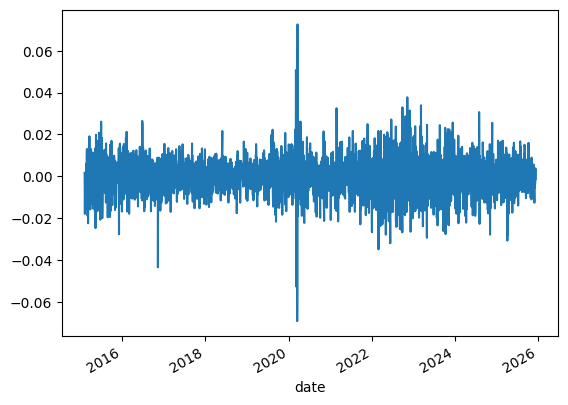

In [19]:
data['log_ret'] = np.log(data.price).diff()
# data.loc[data.price < 100, 'price']
data.log_ret.plot()


In [20]:
# 1. Split Data
split_ratio = 0.5
n = len(data)
split_idx = int(n * split_ratio)

train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

## Historical Volatility Forecasting


In [21]:
hist_data = data.copy()
days_list = [22, 66, 126, 252, 252*2]
# days_list = [22, 252]
alpha = 0.99
z0 = float(scipy.stats.norm.ppf(alpha))

vol_columns = []
mean_columns = []
for days in days_list:
    vol_columns.append(f'vol_{days}d')
    mean_columns.append(f'mean_{days}d')
    hist_data[f'vol_{days}d'] = hist_data['log_ret'].rolling(window=days).std().dropna()
    hist_data[f'mean_{days}d'] = hist_data['log_ret'].rolling(window=days).mean().dropna()
    hist_data[f'value_at_risk_{days}d'] = hist_data[f'mean_{days}d']- z0 * hist_data[f'vol_{days}d']
    hist_data[f'value_at_risk_{days}d'] = hist_data[f'value_at_risk_{days}d'].shift(1).dropna()

# hist_data[mean_columns].plot()

<Axes: title={'center': 'Outlier Percentage'}, xlabel='date'>

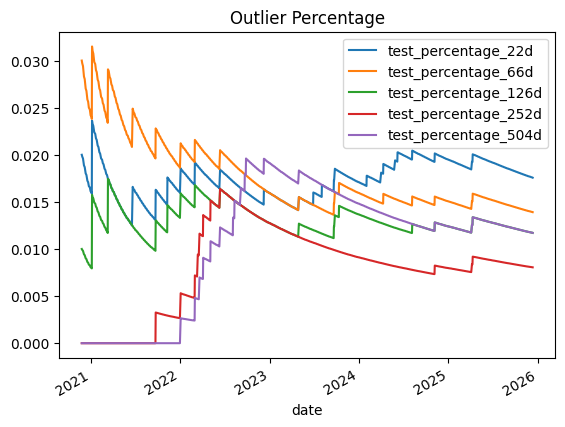

In [22]:
days = 66
test_hist_data = hist_data.iloc[split_idx:].copy()

columns_percentage = []
columns_outlier = []
# test_hist_data['log_ret'].plot()
# test_hist_data[f'value_at_risk_{days}d'].plot()
for days in days_list:
    columns_percentage.append(f'test_percentage_{days}d')
    columns_outlier.append(f'outlier_{days}d')
    test_hist_data[f'outlier_{days}d'] = 0
    test_hist_data.loc[test_hist_data[f'value_at_risk_{days}d'] > test_hist_data['log_ret'], f'outlier_{days}d'] = 1
    test_hist_data[f'test_percentage_{days}d'] = test_hist_data[f'outlier_{days}d'].rolling(window=len(test_hist_data), min_periods=100).sum() 
    test_hist_data[f'test_percentage_{days}d'] /= test_hist_data[f'outlier_{days}d'].rolling(window=len(test_hist_data), min_periods=100).count()
test_hist_data[columns_percentage].plot(title='Outlier Percentage', legend=True)

In [48]:
test_hist_data

,ticker,asset_name,price,log_ret,target_variance,next_day_variance,realized_vol_21d,price_m1,vol_22d,mean_22d,...,mean_252d,value_at_risk_252d,outlier_22d,test_percentage_22d,outlier_66d,test_percentage_66d,outlier_126d,test_percentage_126d,outlier_252d,test_percentage_252d
date,,,,,,,,,,,,,,,,,,,,,
2023-10-09 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),923.000000,0.009908,0.000098,0.000007,0.141901,913.900024,0.008981,0.002577,...,-0.000212,-0.025212,0,NaN,0,NaN,0,NaN,0,NaN
2023-10-10 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),920.549988,-0.002658,0.000007,0.000078,0.135385,923.000000,0.008783,0.001904,...,-0.000240,-0.025220,0,NaN,0,NaN,0,NaN,0,NaN
2023-10-11 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),928.700012,0.008814,0.000078,0.000016,0.130548,920.549988,0.008475,0.001648,...,-0.000182,-0.025241,0,NaN,0,NaN,0,NaN,0,NaN
2023-10-12 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),925.039978,-0.003949,0.000016,0.000143,0.131209,928.700012,0.008133,0.001948,...,-0.000254,-0.025204,0,NaN,0,NaN,0,NaN,0,NaN
2023-10-13 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),936.179993,0.011971,0.000143,0.000009,0.125506,925.039978,0.008357,0.002192,...,-0.000129,-0.025192,0,NaN,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-05 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),917.229980,-0.001329,0.000002,0.000020,0.100520,918.450012,0.006191,-0.001423,...,-0.000248,-0.022412,0,0.017794,0,0.008897,0,0.010676,0,0.010676
2025-12-08 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),921.380005,0.004514,0.000020,0.000002,0.102538,917.229980,0.006304,-0.001075,...,-0.000185,-0.022423,0,0.017762,0,0.008881,0,0.010657,0,0.010657
2025-12-09 00:00:00+00:00,CLP=X,USD/CLP (Chile Peso),922.690002,0.001421,0.000002,0.000010,0.093400,921.380005,0.006326,-0.000941,...,-0.000254,-0.022309,0,0.017730,0,0.008865,0,0.010638,0,0.010638


In [ ]:
from src.models.baseline import GarchBaseline
# ---------------------------------------------------------
# MODEL: GARCH Training
# ---------------------------------------------------------
garch = GarchBaseline(ticker=ticker, data=train_data)
garch.train()

# ---------------------------------------------------------
# DIAGNOSTIC: Meucci's Checklist
# ---------------------------------------------------------
garch.evaluate_fit()

# ---------------------------------------------------------
# BACKTEST
# ---------------------------------------------------------
# garch.run_backtest()


Training GARCH(1,1) ...

   MODEL DIAGNOSTIC REPORT (MEUCCI CHECK)
1. Persistence (alpha + beta): 1.0000
   [FAIL] Model is Explosive (persistence >= 1). INVALID.
2. Significance: Alpha p=0.339, Beta p=0.001
   [WARNING] Some parameters are not significant. Model may be overfitted.
3. Independence (i.i.): Lag-1 Corr = -0.0302, Ljung-Box p = 1.0000
   [PASS] Residuals look independent (White Noise).
4. Stability (i.d.): KS Test p-value = 0.0248
   [FAIL] Distribution changed in second half. Structural Break detected.



(False, ['Explosive', 'Overfitted', 'Residuals Distribution Changed'])

In [ ]:
# garch.run_backtest(test_data)

Generating out-of-sample forecasts...


NameError: name 'split_idx' is not defined

## 4\. Step 3: The Challenger - LSTM with QLIKE Loss

### 4.1 Why MSE fails for Risk

Standard Mean Squared Error (MSE) treats over-prediction and under-prediction symmetrically.

  * **Over-predicting Vol:** You hedge too much (Costly).
  * **Under-predicting Vol:** You blow up (Fatal).

We use **QLIKE (Quasi-Likelihood)** loss, derived from the likelihood of a Gaussian process. It penalizes under-estimation heavily.

$$Loss = \ln(h_t) + \frac{r_t^2}{h_t}$$

  * $h_t$: Predicted Variance
  * $r_t^2$: Realized Variance

### 4.2 Implementation

We implement the custom loss and the LSTM network using PyTorch.


In [ ]:
# Init
from src.models.lstm import DeepVolEngine
# ---------------------------------------------------------
# MODEL: LSTM Training
# ---------------------------------------------------------

engine = DeepVolEngine(ticker=ticker, data=train_data, seq_len=60)

# Train
engine.train()

# # Predict (Get full series)
# pred_vol, true_var = engine.predict(df)


In [ ]:
stop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# ---------------------------------------------------------
# THEORY: The Custom Loss
# ---------------------------------------------------------
class QLIKE_Loss(nn.Module):
    def forward(self, pred_var, target_sq_ret):
        # Loss = log(h) + y^2/h
        loss = torch.log(pred_var) + (target_sq_ret / pred_var)
        return torch.mean(loss)

# ---------------------------------------------------------
# MODEL: LSTM Architecture
# ---------------------------------------------------------
class VolatilityLSTM(nn.Module):
    def __init__(self):
        super(VolatilityLSTM, self).__init__()
        # Input: 1 feature (Log Return)
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)
        self.activation = nn.Softplus() # Ensures Variance > 0

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step = out[:, -1, :] # We only want the forecast for T+1
        var_pred = self.fc(last_step)
        return self.activation(var_pred)

# ---------------------------------------------------------
# PIPELINE: Training Loop
# ---------------------------------------------------------
# Prepare Data Sequences
seq_length = 60
X_list, y_list = [], []
ret_vals = (data['log_ret'].values * 100) # Scaled

for i in range(len(ret_vals) - seq_length):
    X_list.append(ret_vals[i:i+seq_length])
    y_list.append(ret_vals[i+seq_length]**2) # Target is NEXT day variance

X_t = torch.tensor(X_list, dtype=torch.float32).unsqueeze(-1)
y_t = torch.tensor(y_list, dtype=torch.float32)

# Init Model
model_lstm = VolatilityLSTM()
criterion = QLIKE_Loss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.002)

print("Training LSTM...")
losses = []
for epoch in range(30): # Short run for demo
    optimizer.zero_grad()
    outputs = model_lstm(X_t)
    loss = criterion(outputs.squeeze(), y_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("QLIKE Loss Descent")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 5\. Step 4: The Showdown (Backtest)

We perform a rolling Out-of-Sample (OOS) evaluation.

  * **GARCH:** Analytical forecast.
  * **LSTM:** Neural inference.

We compare them using **RMSE** (Accuracy) and **QLIKE** (Risk Safety).

In [ ]:
# ---------------------------------------------------------
# EVALUATION: Generate Forecasts
# ---------------------------------------------------------
# 1. LSTM Forecasts (In-Sample for simplicity of demo)
model_lstm.eval()
with torch.no_grad():
    pred_var_scaled = model_lstm(X_t).squeeze().numpy()

# Rescale back to decimal variance
pred_var_lstm = pred_var_scaled / (100**2)
pred_vol_lstm = np.sqrt(pred_var_lstm) * np.sqrt(252) # Annualize

# 2. GARCH Forecasts (Conditional Volatility from fit)
# Align indices: GARCH returns 'cond_vol' for the same T. 
# We need to slice to match LSTM's "sequence length" loss
garch_vol_raw = res_garch.conditional_volatility[seq_length:] 
garch_vol_ann = (garch_vol_raw / 100) * np.sqrt(252)

# 3. The "Truth" (Realized Volatility Proxy)
# We use a 21-day rolling window of squared returns for the "Truth" plot
# to make it readable (pure squared returns are too noisy to view)
true_sq_returns = data['log_ret'].values[seq_length:]**2
true_vol_proxy = np.sqrt(pd.Series(true_sq_returns).rolling(21).mean()) * np.sqrt(252)

# ---------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

# Plot Truth
plt.plot(true_vol_proxy.values, color='black', label='Realized Vol (21d smooth)', linewidth=2)

# Plot GARCH
plt.plot(garch_vol_ann.values, color='red', label='GARCH(1,1)', alpha=0.7)

# Plot LSTM
plt.plot(pred_vol_lstm, color='blue', label='Deep LSTM (QLIKE)', alpha=0.7)

plt.title("GARCH vs LSTM: Volatility Forecasting Comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Conclusion

By observing the plot:

1.  **GARCH** tends to react smoothly and is mean-reverting.
2.  **LSTM** (with QLIKE) should react more aggressively to sudden spikes, as the loss function penalizes "missing" a crash.